In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns
df = pd.read_csv("datasets/Churn_Modelling.csv")
print(df.shape)
df.head()





(10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [10]:
print(df[['CustomerId', 'Surname','Geography','Gender', 'Age', 'Tenure', 'NumOfProducts', 'IsActiveMember', 'Exited']].agg(pd.Series.nunique).to_frame('counts').to_markdown())

print('Duplicate row counts', len(df[df.duplicated()]))
ndf = df.isnull().agg(['sum', 'count']).T
ndf.columns = ['null_counts', 'Total Records']
print(ndf.to_markdown())

|                |   counts |
|:---------------|---------:|
| CustomerId     |    10000 |
| Surname        |     2932 |
| Geography      |        3 |
| Gender         |        2 |
| Age            |       70 |
| Tenure         |       11 |
| NumOfProducts  |        4 |
| IsActiveMember |        2 |
| Exited         |        2 |
Duplicate row counts 0
|                 |   null_counts |   Total Records |
|:----------------|--------------:|----------------:|
| RowNumber       |             0 |           10000 |
| CustomerId      |             0 |           10000 |
| Surname         |             0 |           10000 |
| CreditScore     |             0 |           10000 |
| Geography       |             0 |           10000 |
| Gender          |             0 |           10000 |
| Age             |             0 |           10000 |
| Tenure          |             0 |           10000 |
| Balance         |             0 |           10000 |
| NumOfProducts   |             0 |           10000 |

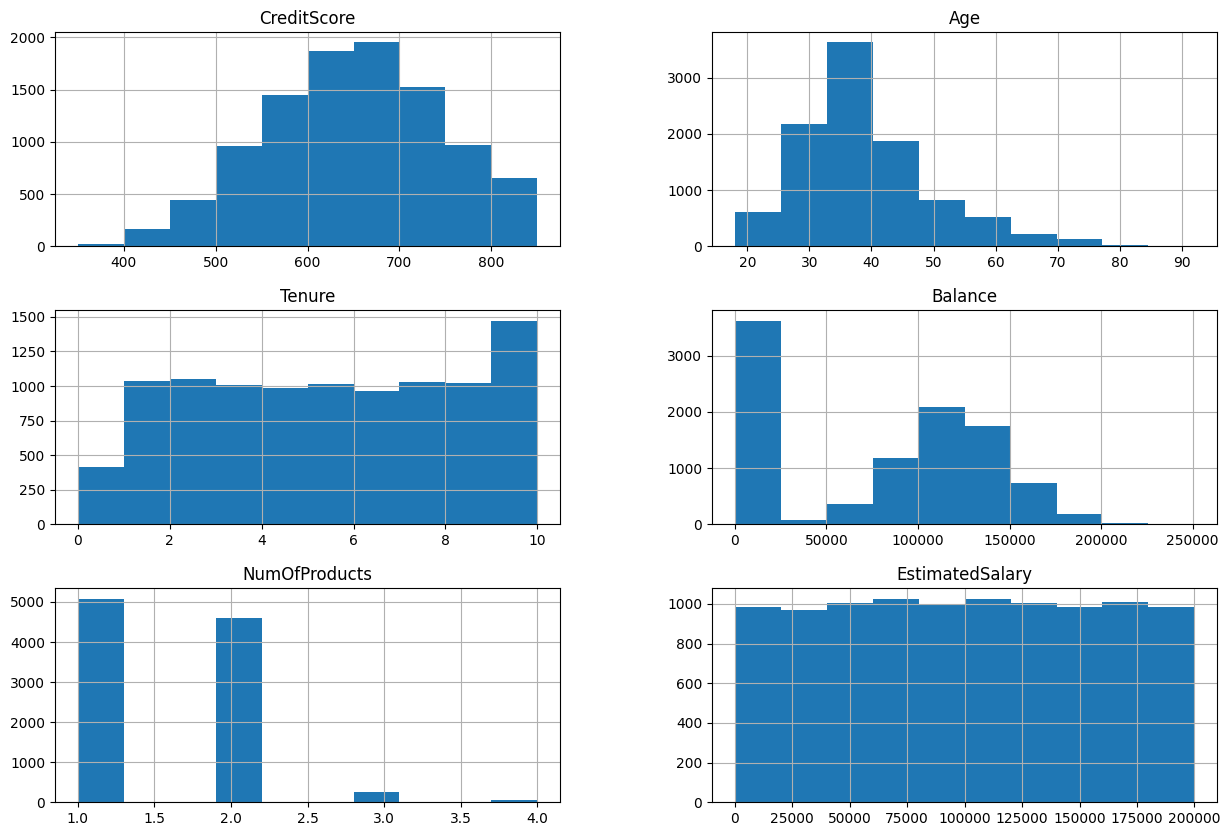

In [12]:
df.hist(column = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary'], figsize=(15, 10))

plt.show()

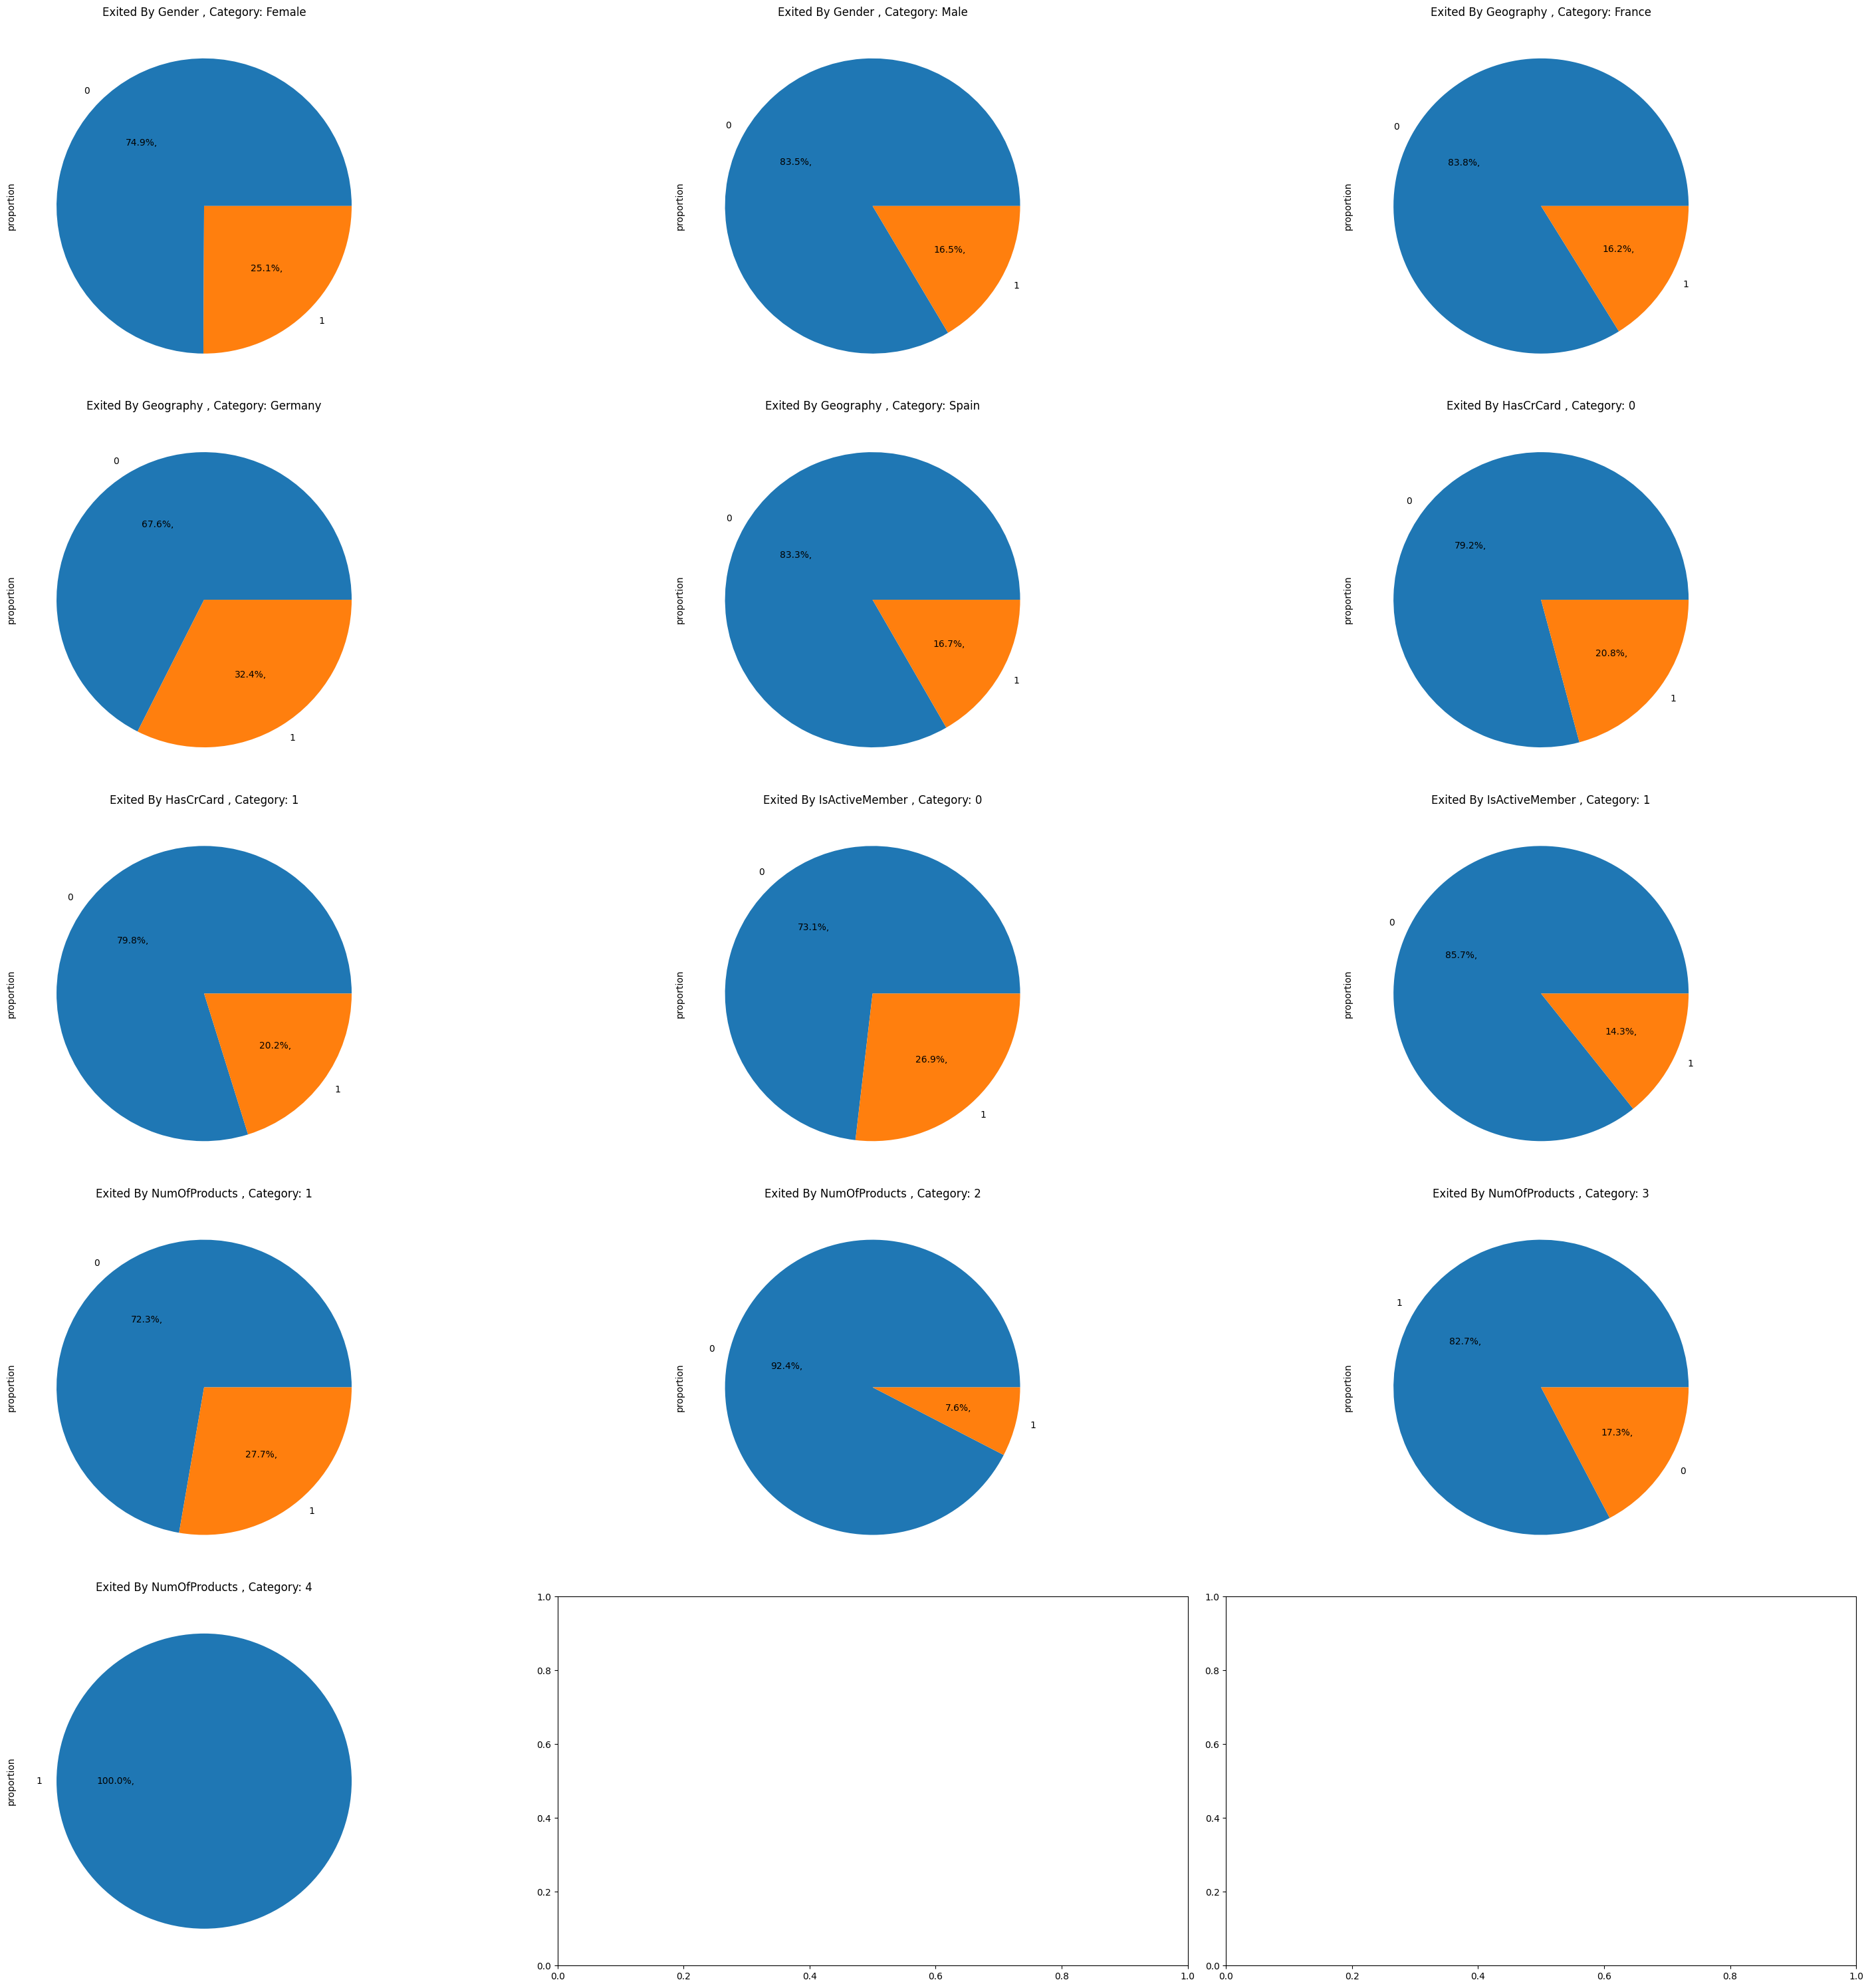

In [14]:
key_columns = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'NumOfProducts']
combinations  = sorted(
    [
        (col, key, group)
        for col in key_columns
        for key, group in df.groupby(col)]
, 
key = lambda x: (x[0], x[1])    
)

fig, axes = plt.subplots((len(combinations)//3)+1, 3, figsize=(30,30))
axes = axes.flatten()

for i, (col,key, group) in enumerate(combinations):
    group['Exited'].value_counts(normalize=True).plot.pie(ax=axes[i], autopct='%1.1f%%,')
    axes[i].set_title(f'Exited By {col} , Category: {key}')

plt.tight_layout()
plt.show()


In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


In [24]:
X = df.drop(['RowNumber', 'CustomerId', 'Surname', "Exited"], axis=1)
y = df['Exited']

X = pd.get_dummies(X, columns= ['Geography', 'Gender'], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True)
}

for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv = 5, scoring='accuracy')
    print(f"{name}: Cross_validation accuracy = {cv_scores.mean():.4f}")

param_grid = {
    'n_estimators':[100, 200, 300], 
    'max_depth': [None, 5, 10]

}

grid_search = GridSearchCV(RandomForestClassifier(random_state=0), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_rf_model = grid_search.best_estimator_
print(f'Best Random Forest hyperparameters: {grid_search.best_params_}')

# Evaluate the best model on the test set
y_pred = best_rf_model.predict(X_test)
print(f'Test Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print(f'Precision: {precision_score(y_test, y_pred):.4f}')
print(f'Recall: {recall_score(y_test, y_pred):.4f}')
print(f'F1-score: {f1_score(y_test, y_pred):.4f}')
print(f'ROC AUC: {roc_auc_score(y_test, best_rf_model.predict_proba(X_test)[:, 1]):.4f}')



Logistic Regression: Cross_validation accuracy = 0.8088
Decision Tree: Cross_validation accuracy = 0.7925
Random Forest: Cross_validation accuracy = 0.8619
Gradient Boosting: Cross_validation accuracy = 0.8624
SVM: Cross_validation accuracy = 0.8528
Best Random Forest hyperparameters: {'max_depth': 10, 'n_estimators': 200}
Test Accuracy: 0.8720
Precision: 0.7922
Recall: 0.4988
F1-score: 0.6121
ROC AUC: 0.8771
